In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from label_transfer_predictions import LabelTransferPredictor
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt

In [2]:
datasets = pd.read_csv('datasets.csv')
datasets = datasets[~datasets['study_id'].isin(['Ho2020M', 'Ho2020F'])]

predictor = LabelTransferPredictor(hyperparams_file='hyperparams.csv',
                               data_dir='exported_matrices',
                               output_dir='label_transfer_model_output/predictions/',
                               verbose=False,
                               random_seed=12345)

In [3]:
for dataset in datasets['study_id'].unique():    
    print(f'Predicting labels for {dataset}')
    predictions = predictor.predict_dataset(dataset)
    predictor.plot_predictions_on_UMAP(dataset, predictions, display=False, save=True)  
    # Save predictions to file
    predictions.to_csv(f'label_transfer_model_output/{dataset}_label_transfer_predictions.csv', index=False)

Predicting labels for Ruf_Zamojski2021F


I0000 00:00:1737796197.729052  741899 service.cc:145] XLA service 0x7fb6b0006660 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737796197.729442  741899 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6


65/80 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step 

I0000 00:00:1737796197.953794  741899 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predicting labels for Ruf_Zamojski2021M
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Predicting labels for Lopez2021M
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicting labels for Allensworth2021F
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Predicting labels for Vennekens2021M
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
17/17 ━━━━━━━━━━━━━━━━━━━

<Figure size 640x480 with 0 Axes>

In [4]:
all_saliency_maps = {}
saliency_maps_summary = {}


for dataset in tqdm(datasets['study_id'].unique(), desc='Computing saliency maps'):
    expr_data = predictor.get_data(dataset)
    saliency_maps_summary[dataset], all_saliency_maps[dataset] = predictor.get_saliency(dataset)

Computing saliency maps:   0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
saliency_maps_df = pd.DataFrame()
for dataset in saliency_maps_summary:
    for cluster in saliency_maps_summary[dataset]:
        saliency_maps_df = pd.concat([saliency_maps_df, saliency_maps_summary[dataset][cluster].assign(dataset=dataset, cluster=cluster)])

saliency_maps_df.reset_index(inplace=True)

# Sort by |saliency mean| in each cluster/dataset then get the top 10 genes
saliency_maps_df = (
    saliency_maps_df.groupby(['dataset', 'cluster'], group_keys=False)
    .apply(lambda group: group.sort_values('Saliency_mean', key=abs, ascending=False))
    .reset_index(drop=True)
)

# Remove extra cluster column (there is a Cluster column already)
saliency_maps_df.drop(columns=['cluster'], inplace=True)

top_10_genes = saliency_maps_df.groupby(['dataset', 'Cluster']).head(10).reset_index(drop=True)
top_100_genes = saliency_maps_df.groupby(['dataset', 'Cluster']).head(100).reset_index(drop=True)

top_10_genes.to_csv('label_transfer_model_output/top_genes.csv', index=False)
top_100_genes.to_csv('label_transfer_model_output/top_100_genes.csv', index=False)

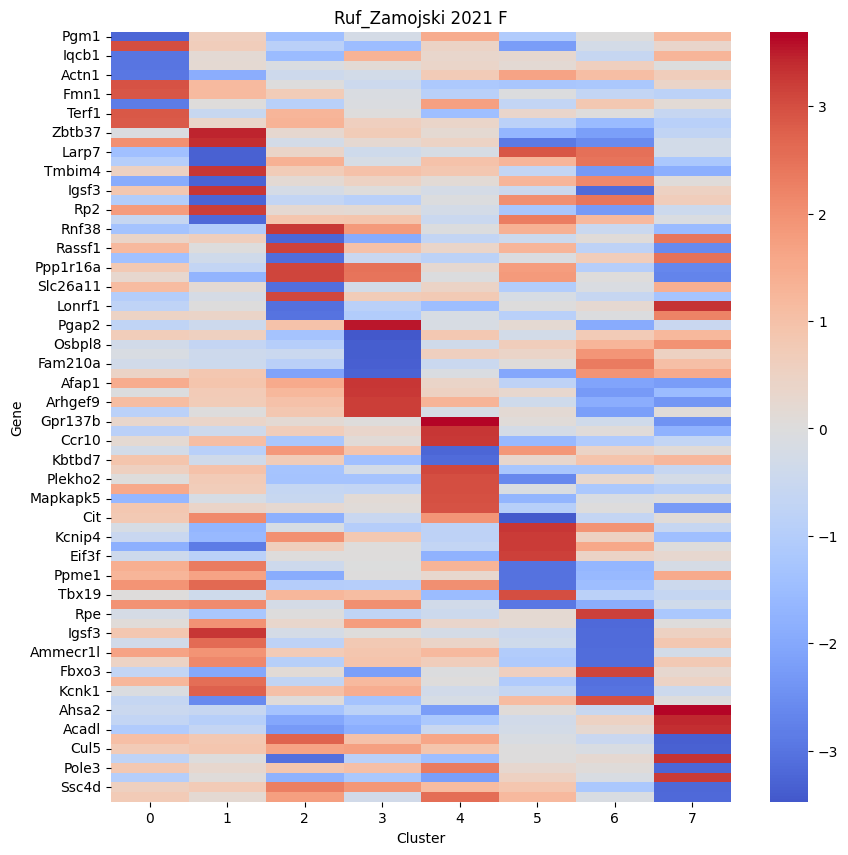

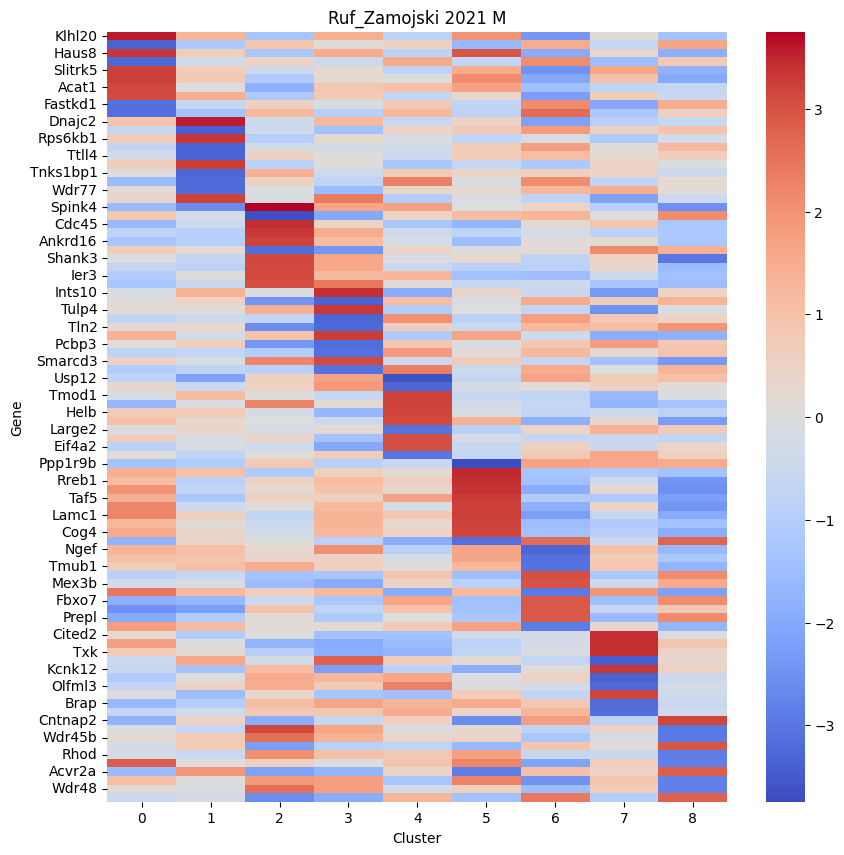

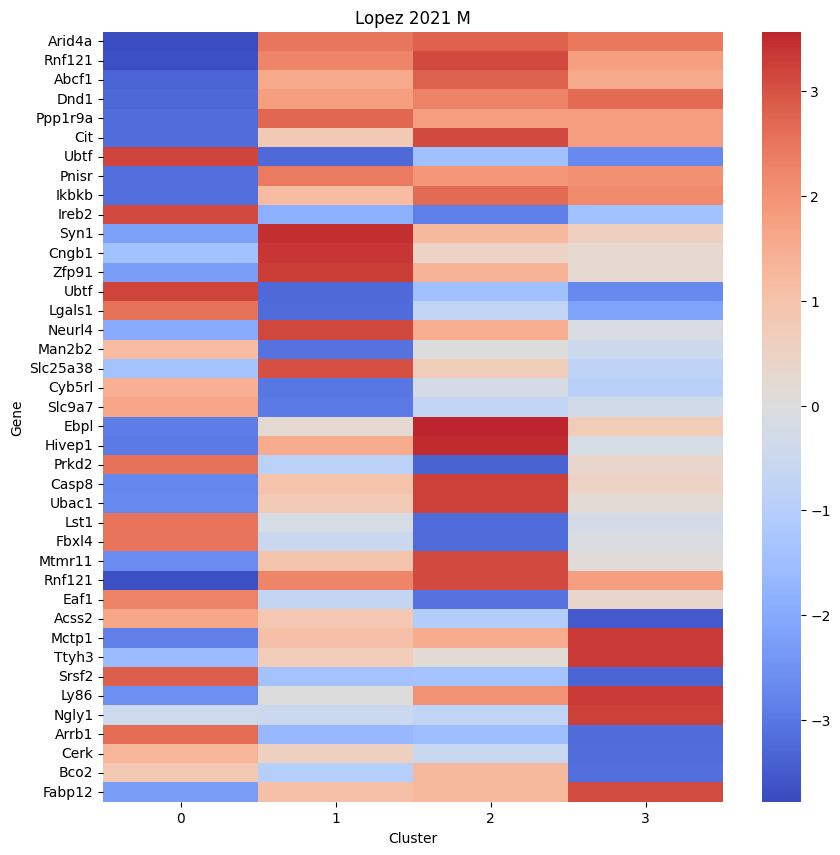

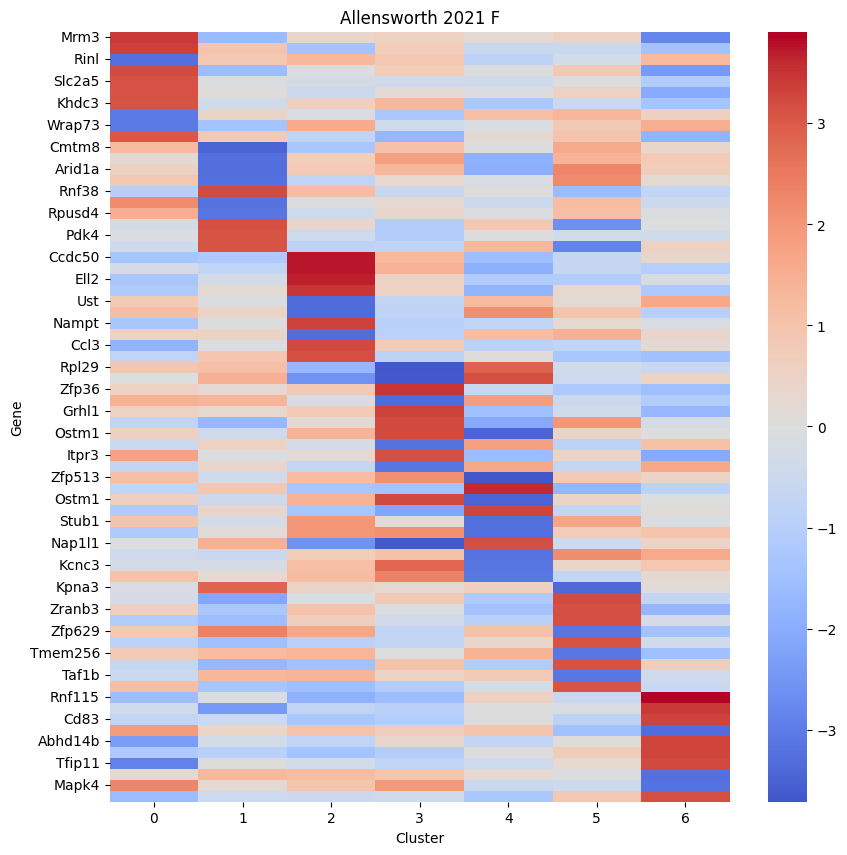

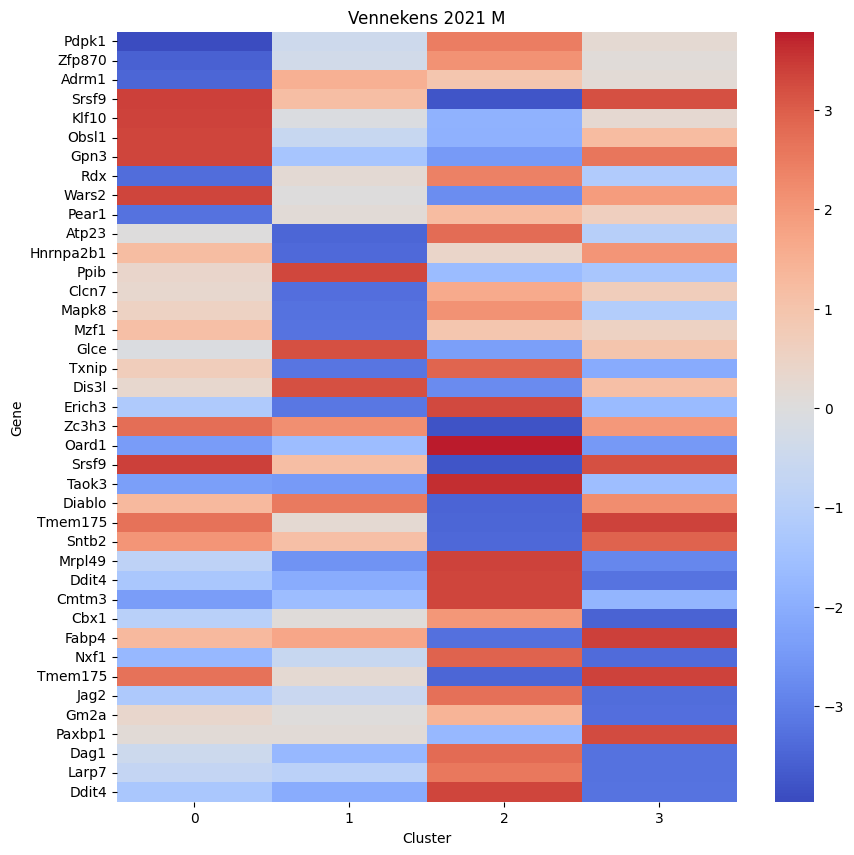

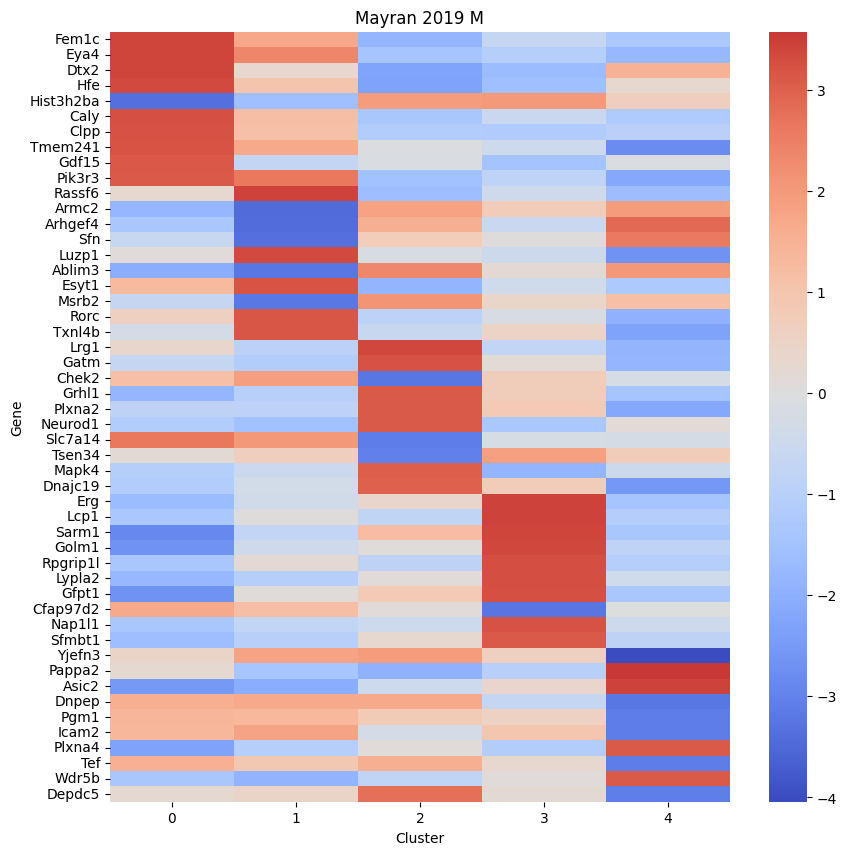

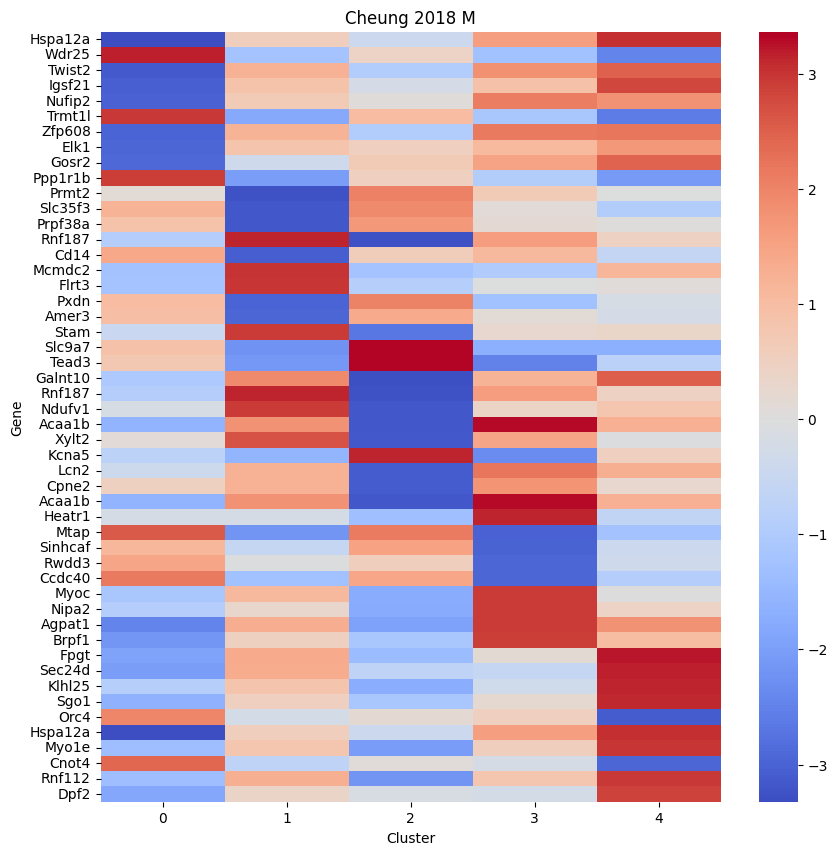

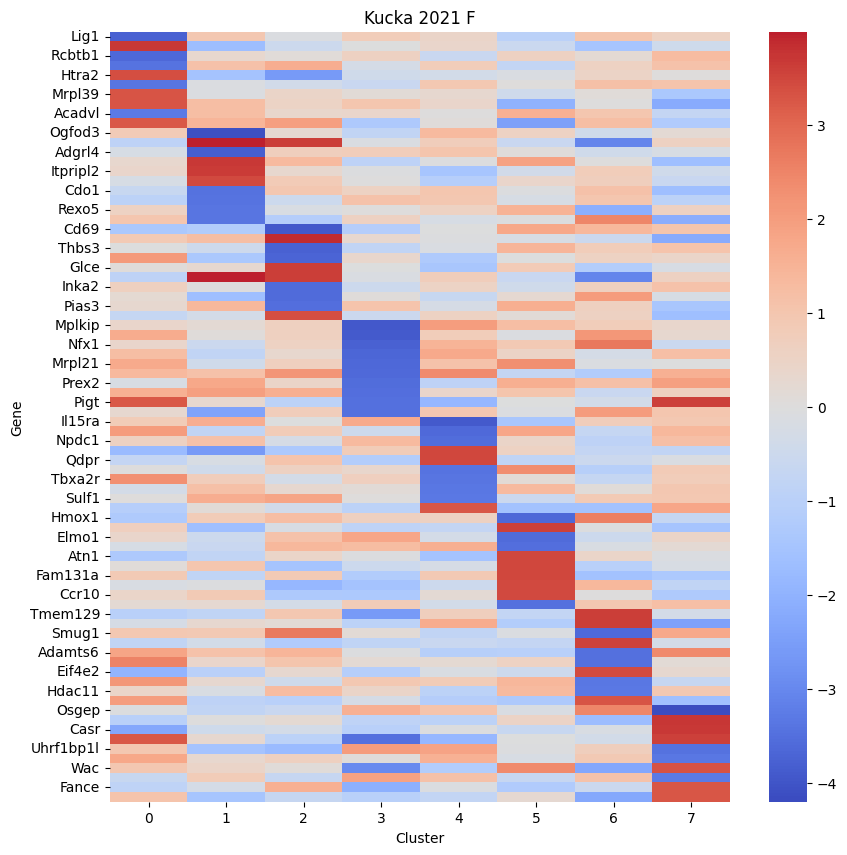

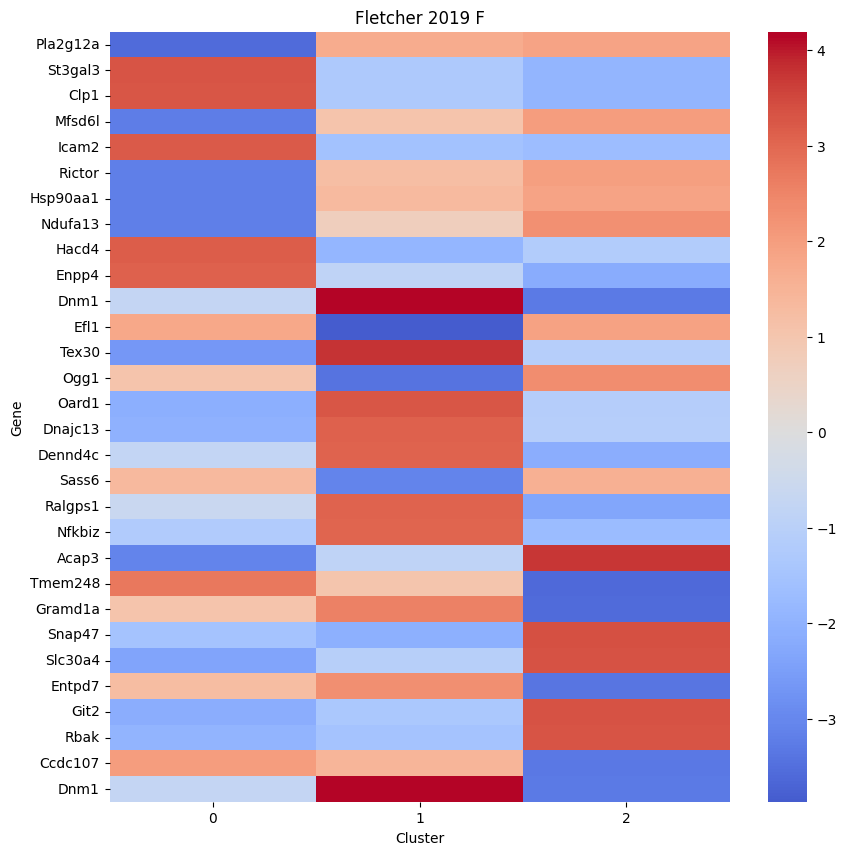

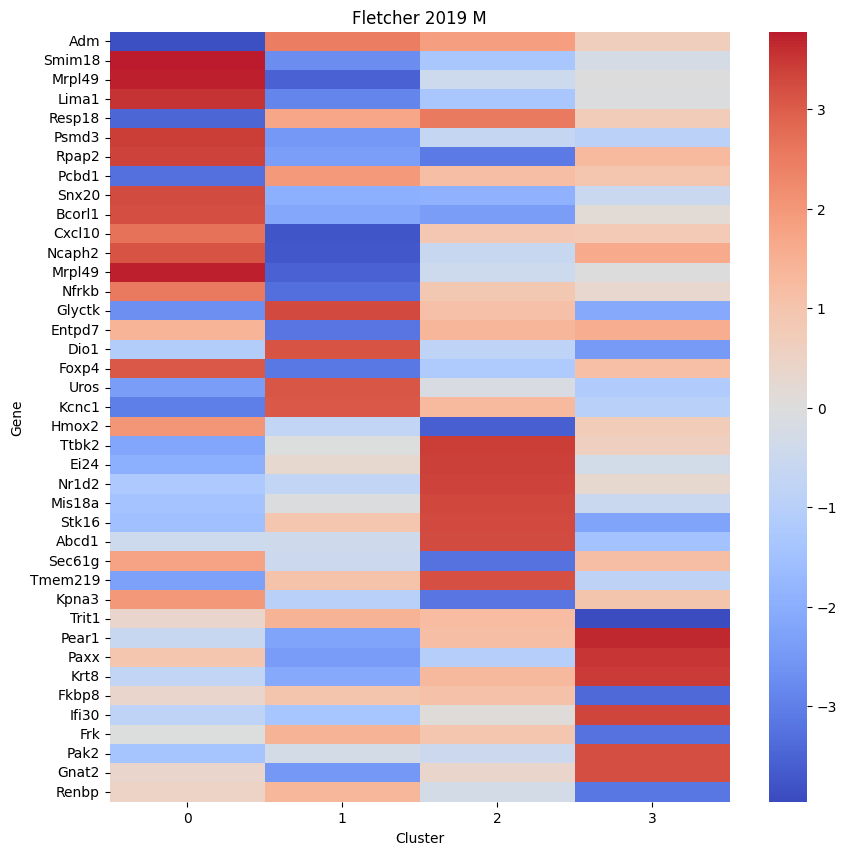

In [6]:
gene_names = predictor.get_data('Cheung2018M').columns[:-2]

def plot_top_genes(dataset):

    # Heatmap
    # Concatenate all saliency maps for the dataset
    vals = pd.concat(saliency_maps_summary[dataset].values(), keys=saliency_maps_summary[dataset].keys()).reset_index()
    # Drop unnecessary columns
    vals.drop(columns=['level_0', 'Saliency_sd'], inplace=True)
    # Set Gene as index, then pivot wide
    vals = vals.set_index('Gene')    
    vals = vals.pivot(columns='Cluster', values='Saliency_mean')
    # Limit to top genes
    tg = top_10_genes[top_10_genes['dataset'] == dataset]['Gene']    

    # Plot heatmap and save to PDF
    plt.figure(figsize=(10, 10))
    sns.heatmap(vals.loc[tg], cmap='coolwarm', center=0)
    plt.title(f'{dataset[:-5]} {dataset[-5:-1]} {dataset[-1:]}')    
    plt.savefig(f'label_transfer_model_output/{dataset}_saliency_heatmap.pdf')
    plt.show()
    
    # # Violin plot
    # fig, ax = plt.subplots(2, n_clusters//2, figsize=(15, 15))
    # for i, a in enumerate(ax.flat):
    #     top_g = top_genes[(top_genes['dataset'] == dataset) & (top_genes['Cluster'] == clusters[i])]
    #     saliency_values = all_saliency_maps[dataset][clusters[i]]
    #     saliency_values = pd.DataFrame(np.squeeze(np.array(saliency_values)), columns= gene_names)
                
    #     sns.violinplot(data=saliency_values[top_g['Gene']], color = "white", orient = "h", ax=a)
    #     a.set_xlabel('Saliency value (z-scored)')
    #     a.set_xlim(-10, 10)
    #     a.set_title(f'Dataset {dataset[:-5]} {dataset[-5:-1]} {dataset[-1:]} - Cluster {clusters[i]}')
    # plt.show()
    
for dataset in datasets['study_id'].unique():
    plot_top_genes(dataset)

In [12]:
for dataset in datasets['study_id'].unique():
    print(f"****{dataset}****")
    marker_genes = pd.read_csv(f'markers/{dataset}_markers.csv', index_col=0)        
    # How many of the top genes for each cluster are also marker genes for the same cluster?    
    for cluster in saliency_maps_summary[dataset].keys():
        top = top_100_genes[(top_100_genes['dataset'] == dataset) & (top_100_genes['Cluster'] == cluster)]
        n_top_genes = len(top)
        n_marker_genes = len(marker_genes[marker_genes['cluster'] == cluster])
        n_overlap = len(set(top['Gene']).intersection(set(marker_genes[marker_genes['cluster'] == cluster].index)))

        print(f'Cluster {cluster}: {n_overlap} out of {n_top_genes} top genes are also marker genes ({n_overlap/n_top_genes*100:.2f}%)')

****Ruf_Zamojski2021F****
Cluster 5: 1 out of 100 top genes are also marker genes (1.00%)
Cluster 6: 0 out of 100 top genes are also marker genes (0.00%)
Cluster 4: 0 out of 100 top genes are also marker genes (0.00%)
Cluster 3: 1 out of 100 top genes are also marker genes (1.00%)
Cluster 2: 1 out of 100 top genes are also marker genes (1.00%)
Cluster 1: 1 out of 100 top genes are also marker genes (1.00%)
Cluster 0: 0 out of 100 top genes are also marker genes (0.00%)
Cluster 7: 1 out of 100 top genes are also marker genes (1.00%)
****Ruf_Zamojski2021M****
Cluster 2: 0 out of 100 top genes are also marker genes (0.00%)
Cluster 6: 13 out of 100 top genes are also marker genes (13.00%)
Cluster 8: 0 out of 100 top genes are also marker genes (0.00%)
Cluster 1: 0 out of 100 top genes are also marker genes (0.00%)
Cluster 4: 1 out of 100 top genes are also marker genes (1.00%)
Cluster 3: 3 out of 100 top genes are also marker genes (3.00%)
Cluster 0: 3 out of 100 top genes are also marker 

In [ ]:
import shap
import matplotlib.pyplot as plt

model = predictor.models['Cheung2018M']
expr_data_train, expr_data_test, _, _ = predictor._load_data('Cheung2018M')

In [ ]:
feature_names = expr_data_test.columns.values
train_sample = expr_data_train.sample(100).values

# Create a DeepExplainer object
explainer = shap.DeepExplainer(model, train_sample)

# Explain predictions for test data
shap_values = explainer(expr_data_test.values)

In [ ]:
# shap.summary_plot(shap_values[:,:,0], expr_data_test.values, feature_names=feature_names, plot_type="bar")

n_classes = shap_values.shape[2]
fig, ax = plt.subplots(n_classes//3 + 1, 3, figsize=(15, 5*n_classes//3))
for i in range(n_classes):
    shap.summary_plot(shap_values[:,:,1], expr_data_test.values, feature_names=feature_names, plot_type="bar")
    ax.flat[i].set_title(f'Class {i}')    
plt.tight_layout()
plt.show()

### Calculate SHAP values for all datasets/clusters

In [ ]:
def top_SHAP(dataset: str, mean_shap_per_cluster: pd.DataFrame, save: bool = False, plot: bool = True) -> None:
    """
    Gets the top and bottom 10 SHAP values for each cluster. If requested, saves the values to CSV and/or plots them.
    
    Parameters
    ----------
    dataset : str
        The name of the dataset.
    mean_shap_per_cluster : pd.DataFrame
        The mean SHAP values for each cluster.
    save : bool, optional, default = False
        Whether to save the data to a CSV file.
    plot : bool, optional, default = True
        Whether to plot the data.
    """
    mean_shap_per_cluster_long = mean_shap_per_cluster.reset_index().rename(columns={'index': 'Gene'})
    mean_shap_per_cluster_long = mean_shap_per_cluster_long.melt(id_vars = ['Gene'], var_name = 'Cluster', value_name = 'SHAP value')
    mean_shap_per_cluster_long['Positive_SHAP'] = mean_shap_per_cluster_long['SHAP value'] > 0
    mean_shap_per_cluster_long['Positive_SHAP'] = mean_shap_per_cluster_long['Positive_SHAP'].astype(int)
    mean_shap_per_cluster_long = mean_shap_per_cluster_long.dropna(subset=['SHAP value'])
    mean_shap_per_cluster_long = mean_shap_per_cluster_long.sort_values(by=['Cluster', 'SHAP value'], ascending=[True, False])

    if save:
        mean_shap_per_cluster_long.to_csv(os.path.join(output_dir, f"{dataset}_top_bottom_shap.csv"), index=False)
    if plot:
        p = sns.catplot(data = mean_shap_per_cluster_long, x = 'Gene', y = 'SHAP value', col = 'Cluster', 
                        hue = 'Positive_SHAP', kind = 'bar', col_wrap = 2, sharex=False)

        for ax in p.axes.flat:
            for label in ax.get_xticklabels():
                label.set_rotation(90)
            
        p.figure.suptitle(f'Top and bottom 10 features for dataset {dataset}')
        p.figure.tight_layout()
        p.figure.subplots_adjust(top=0.9) 

        p._legend.remove()

        plt.show()

for dataset in set(datasets['study_id']):
    hp = get_hyperparameters(dataset)

    features = models[dataset].get_booster().feature_names

    _, expr_test, _, cluster_test = load_data(dataset)
    print(f"Calculating SHAP values for {dataset}")
    explainer = shap.Explainer(models[dataset])
    shap_values = explainer(expr_test)
    mean_shap_per_cluster = pd.DataFrame()
    for cluster in range(hp['num_classes']):
        # Get the mean SHAP values for each feature, sorted by importance
        sorted_shap = pd.DataFrame(shap_values.values[:,:,cluster], columns = features).mean().sort_values(ascending=False)
        # Get the top and bottom 10 features
        top_and_bottom = pd.concat([sorted_shap.head(10), sorted_shap.tail(10)])
        top_and_bottom.name = f"Cluster {cluster}"
        mean_shap_per_cluster = pd.concat([mean_shap_per_cluster, top_and_bottom], axis=1)
    top_SHAP(dataset, mean_shap_per_cluster, save = True, plot = True)        

In [ ]:
mean_shap_per_cluster_long = mean_shap_per_cluster.reset_index().rename(columns={'index': 'Gene'})
mean_shap_per_cluster_long = mean_shap_per_cluster_long.melt(id_vars = ['Gene'], var_name = 'Cluster', value_name = 'SHAP value')
mean_shap_per_cluster_long['Positive_SHAP'] = mean_shap_per_cluster_long['SHAP value'] > 0
mean_shap_per_cluster_long['Positive_SHAP'] = mean_shap_per_cluster_long['Positive_SHAP'].astype(int)
mean_shap_per_cluster_long = mean_shap_per_cluster_long.dropna(subset=['SHAP value'])
mean_shap_per_cluster_long = mean_shap_per_cluster_long.sort_values(by=['Cluster', 'SHAP value'], ascending=[True, False])

p = sns.catplot(data = mean_shap_per_cluster_long, x = 'Gene', y = 'SHAP value', col = 'Cluster', hue = 'Positive_SHAP', kind = 'bar', col_wrap = 2,
            sharex=False)

for ax in p.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
       
p.figure.suptitle('Top and bottom 10 SHAP values for each cluster for dataset {dataset}')
p.figure.tight_layout()
p.figure.subplots_adjust(top=0.9) 

p._legend.remove()

plt.show()

In [ ]:
def plot_saliency_bars(dataset:str, cluster:int, n_genes:int = 10, where:str = "top") -> None:
    """
    Plot the saliency of the top n_genes genes for a given cluster in a given dataset.
    
    Parameters
    ----------
    
    dataset: str, cluster:int
        The dataset and cluster to plot the saliency for.
    n_genes: int
        The number of genes to plot.
    where: str
        One of "top", "bottom" or "both". Whether to plot the top, bottom or both top and bottom n_genes (in total).    
    """
    
    if where == "top":
        saliency[dataset][cluster].sort_values(by="Saliency_mean", ascending=False).head(n_genes)['Saliency_mean'].plot.bar()
    elif where == "bottom":
        saliency[dataset][cluster].sort_values(by="Saliency_mean", ascending=True).head(n_genes)['Saliency_mean'].plot.bar()
    elif where == "both":
        saliency[dataset][cluster].sort_values(by='Saliency_mean', ascending=False, key=abs).head(n_genes)["Saliency_mean"].sort_values(ascending = False).plot.bar()
    
plot_saliency_bars("Cheung2018M", 0, 10, "top")

In [ ]:
def plot_saliency_on_umap(dataset: str, cluster: int, n_genes: int = 10, where: str = "top") -> None:
    """
    Plot the saliency of the top n_genes genes for a given cluster in a given dataset on the UMAP.

    Parameters
    ----------

    dataset: str, cluster:int
        The dataset and cluster to plot the saliency for.
    n_genes: int
        The number of genes to plot.
    where: str
        One of "top", "bottom" or "both". Whether to plot the top, bottom or both top and bottom n_genes (in total).    
    """

    umap = predictor.umaps[dataset]
    expr = predictor.expression_data[dataset]

    genes = []

    if where == "top":
        genes = saliency[dataset][cluster].sort_values(
            by="Saliency_mean", ascending=False).head(n_genes).index
    elif where == "bottom":
        genes = saliency[dataset][cluster].sort_values(
            by="Saliency_mean", ascending=True).head(n_genes).index
    elif where == "both":
        genes = saliency[dataset][cluster].sort_values(by='Saliency_mean', ascending=False, key=abs).head(
            n_genes)["Saliency_mean"].sort_values(ascending=False).index

    n_row = int(sqrt(n_genes))
    n_col = ceil(n_genes / n_row)    
    
    fig, ax = plt.subplots(n_row, n_col, figsize=(10, 10))
    
    for i, g in enumerate(genes):
        a = ax.ravel()[i]
        a.scatter(umap["UMAP_1"], umap["UMAP_2"], c=expr[g], cmap="viridis", s=5, alpha=0.5)
        a.set_title(g)
        
    for a in ax.ravel():
        a.axis("off")

plot_saliency_on_umap("Cheung2018M", 0, 12, "bottom")